In [1]:
import pandas as pd
import numpy as np
import random
import math
from gravity_utils import *
import json
from datetime import timedelta as td
from datetime import time
from datetime import datetime
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt


import sys
sys.path.insert(1, '../DRTsim')
#import utils, const
#from utils import Activity, Coord
#from const import ActivityType
from shapely.geometry import Point
import shapely.wkt

# Time distribution

In [2]:
resfil_raw = pd.read_csv('data/rvu/RVU_resfil.csv')
resfil_raw = resfil_raw.loc[:, ['kl6_km','rf1_Samskod','rf4_Samskod','rf2_starttid','individvikt', 'ärende_2', 'Id', 'rf6_ankomsttid']]
#rf2_starttid: Hur dags startade du? (99: oläsligt svar)
#individvikt: Uppräkningsvikt till population (kalibrerad)
#ärende_2: Ärendevariabel som ska användas! Sammanslagning ärende till färre klasser (1=arbete, 10=hemresa)
#id: Id-nummer
#rf6_ankomsttid: Ankomsttid

#df_resfil = df_resfil[df_resfil['ärende_2']==1]
upsampled_resfil = draw_population(resfil_raw, resfil_raw.individvikt.astype(int))

## Work length distribution

In [3]:
def get_time_distr(resfil):
    times_binned = pd.cut(resfil.time_int, pd.interval_range(start=0, end=24, freq=0.25, closed='left'))
    time_distribution_raw = times_binned.value_counts().sort_index().values
    return pd.DataFrame(np.convolve(time_distribution_raw, np.ones((4,))/4, mode='same'), \
                          index=times_binned.cat.categories, columns=['total'])

In [4]:
resfil_time_length = resfil_raw[(resfil_raw['ärende_2'] == 1) | (resfil_raw['ärende_2'] == 10)]

In [5]:
resfil_time_length = resfil_time_length.dropna()
resfil_time_length

,kl6_km,rf1_Samskod,rf4_Samskod,rf2_starttid,individvikt,ärende_2,Id,rf6_ankomsttid
5,4.0,12830006.0,12830039.0,14:19,22.281823,10.0,1000116.0,15:40
9,5.0,12850024.0,12810071.0,12:30,10.434358,10.0,1000207.0,13:09
11,1.0,12810066.0,12810071.0,16:45,10.434358,10.0,1000207.0,16:55
16,3.0,12800266.0,12800195.0,7:00,93.653602,1.0,1000413.0,7:20
17,3.0,12800195.0,12800266.0,16:00,93.653602,10.0,1000413.0,16:20
...,...,...,...,...,...,...,...,...
56303,5.0,12870026.0,12870022.0,20:00,28.950126,10.0,1187400.0,21:00
56313,2.0,12800235.0,12800256.0,15:43,102.874352,10.0,1383249.0,16:30
56318,4.0,12830030.0,12830033.0,18:00,11.837775,10.0,1461201.0,18:20
56326,2.0,12810019.0,12810056.0,17:30,4.394781,10.0,1551902.0,17:40


In [6]:
resfil_time_length = resfil_time_length.set_index('Id')

In [7]:
resfil_time_length.loc[:, 'rf2_starttid'] = resfil_time_length.rf2_starttid.replace({'99': np.NaN,
                                                                          '18.45': '18:45',
                                                                          '1900-': '19:00',
                                                                          '1 9:4': '19:4'})

resfil_time_length.loc[:, 'rf6_ankomsttid'] = resfil_time_length.rf6_ankomsttid.replace({'99': np.NaN,
                                                                          '18.45': '18:45',
                                                                          '1900-': '19:00',
                                                                          '1 9:4': '19:4'})

resfil_time_length = resfil_time_length.dropna()

resfil_time_length

,kl6_km,rf1_Samskod,rf4_Samskod,rf2_starttid,individvikt,ärende_2,rf6_ankomsttid
Id,,,,,,,
1000116.0,4.0,12830006.0,12830039.0,14:19,22.281823,10.0,15:40
1000207.0,5.0,12850024.0,12810071.0,12:30,10.434358,10.0,13:09
1000207.0,1.0,12810066.0,12810071.0,16:45,10.434358,10.0,16:55
1000413.0,3.0,12800266.0,12800195.0,7:00,93.653602,1.0,7:20
1000413.0,3.0,12800195.0,12800266.0,16:00,93.653602,10.0,16:20
...,...,...,...,...,...,...,...
1187400.0,5.0,12870026.0,12870022.0,20:00,28.950126,10.0,21:00
1383249.0,2.0,12800235.0,12800256.0,15:43,102.874352,10.0,16:30
1461201.0,4.0,12830030.0,12830033.0,18:00,11.837775,10.0,18:20


In [8]:
from datetime import timedelta
d = []
i = []
w = []
t1 = []
t2 = []
t3 = []
t4 = []
l = []
sams1 = []
sams2 = []

for ind in resfil_time_length.index:
    x = resfil_time_length.loc[ind]
    if len(x) > 2:
        continue
    if 10 not in x['ärende_2'].values or 1 not in x['ärende_2'].values:
        continue

    
    work_start_time = x[x['ärende_2'] == 1]['rf6_ankomsttid']
    work_end_time = x[x['ärende_2'] == 10]['rf2_starttid']
    
    work_journey_start_time = x[x['ärende_2'] == 1]['rf2_starttid']
    home_journey_start_time = x[x['ärende_2'] == 10]['rf2_starttid']
    
    work_end_samskod = x[x['ärende_2'] == 1]['rf4_Samskod'].values[0]
    home_start_samskod = x[x['ärende_2'] == 10]['rf1_Samskod'].values[0]
    
    s = work_start_time.values[0].split(':')
    work_start_time = datetime(year = 1970, month = 1 ,day = 1,hour = int(s[0]), minute = int(s[1]))
    
    e = work_end_time.values[0].split(':')
    work_end_time = datetime(year = 1970, month = 1 ,day = 1,hour = int(e[0]), minute = int(e[1]))
    
    s = work_journey_start_time.values[0].split(':')
    work_journey_start_time = datetime(year = 1970, month = 1 ,day = 1,hour = int(s[0]), minute = int(s[1]))
    
    e = home_journey_start_time.values[0].split(':')
    home_journey_start_time = datetime(year = 1970, month = 1 ,day = 1,hour = int(e[0]), minute = int(e[1]))
    
    if(work_end_time < work_start_time):
        work_end_time = work_end_time + timedelta(days=1)

    duration = abs(work_end_time - work_start_time)
    if(work_end_samskod == home_start_samskod  and home_start_samskod != 0 and duration.seconds >= 3600 and duration.seconds <= 72000): 
        #no journeys <1h or >20h AND origin sams of work trip == destination sams of home trip
        d.append(duration)
        i.append(str(ind))
        w.append(x['individvikt'].values[0])
        t1.append(work_start_time.hour + work_start_time.minute/60)
        t2.append(str(work_end_time))
        t3.append(work_journey_start_time.hour + work_journey_start_time.minute/60)
        t4.append(home_journey_start_time.hour + home_journey_start_time.minute/60)
        sams1.append(int(home_start_samskod))
        sams2.append(int(work_end_samskod))
        l.append(str(x[x['ärende_2'] == 1]['kl6_km'].values[0]))
work_length_tmp = pd.DataFrame(data=[i,d,w,t1,t2,t3,t4,l,sams1,sams2])

In [9]:
work_length = work_length_tmp.T
work_length.columns = ['Id', 'time', 'weight', 'work_start_time', 'work_end_time', 'work_journey_start_time', 'home_journey_start_time', 'trip_length', 'home_start_samskod', 'work_end_samskod']
work_length.drop_duplicates(subset ="Id", 
                     keep = 'first', inplace = True)

work_length = work_length.sort_values(by=['time'])
work_length

,Id,time,weight,work_start_time,work_end_time,work_journey_start_time,home_journey_start_time,trip_length,home_start_samskod,work_end_samskod
4446,1582287.0,01:00:00,79.1399,8,1970-01-01 09:00:00,7.21667,9,4.0,12800345,12800345
3384,1462464.0,01:00:00,19.759,9,1970-01-01 10:00:00,8.5,10,5.0,12900069,12900069
4720,1669720.0,01:10:00,15.6397,10.6667,1970-01-01 11:50:00,10.5,11.8333,2.0,12330005,12330005
2354,1352632.0,01:11:00,36.8892,15.8167,1970-01-01 17:00:00,15,17,2.0,12810088,12810088
474,1057439.0,01:26:00,29.1404,13.8667,1970-01-01 15:18:00,13.6167,15.3,3.0,12630002,12630002
...,...,...,...,...,...,...,...,...,...,...
4664,1643972.0,15:32:00,59.0945,9.3,1970-01-02 00:50:00,9.25,0.833333,2.0,12140014,12140014
462,1056670.0,15:40:00,97.5919,12.3333,1970-01-02 04:00:00,12,4,2.0,12810013,12810013
1882,1215045.0,15:50:00,71.5745,5.16667,1970-01-01 21:00:00,5,21,2.0,12900038,12900038
2978,1416874.0,16:04:00,80.9919,6.61667,1970-01-01 22:41:00,6,22.6833,5.0,12810002,12810002


In [10]:
work_length['time_int'] = work_length.time.apply(lambda x: x.seconds / 3600)
work_length

,Id,time,weight,work_start_time,work_end_time,work_journey_start_time,home_journey_start_time,trip_length,home_start_samskod,work_end_samskod,time_int
4446,1582287.0,01:00:00,79.1399,8,1970-01-01 09:00:00,7.21667,9,4.0,12800345,12800345,1.000000
3384,1462464.0,01:00:00,19.759,9,1970-01-01 10:00:00,8.5,10,5.0,12900069,12900069,1.000000
4720,1669720.0,01:10:00,15.6397,10.6667,1970-01-01 11:50:00,10.5,11.8333,2.0,12330005,12330005,1.166667
2354,1352632.0,01:11:00,36.8892,15.8167,1970-01-01 17:00:00,15,17,2.0,12810088,12810088,1.183333
474,1057439.0,01:26:00,29.1404,13.8667,1970-01-01 15:18:00,13.6167,15.3,3.0,12630002,12630002,1.433333
...,...,...,...,...,...,...,...,...,...,...,...
4664,1643972.0,15:32:00,59.0945,9.3,1970-01-02 00:50:00,9.25,0.833333,2.0,12140014,12140014,15.533333
462,1056670.0,15:40:00,97.5919,12.3333,1970-01-02 04:00:00,12,4,2.0,12810013,12810013,15.666667
1882,1215045.0,15:50:00,71.5745,5.16667,1970-01-01 21:00:00,5,21,2.0,12900038,12900038,15.833333
2978,1416874.0,16:04:00,80.9919,6.61667,1970-01-01 22:41:00,6,22.6833,5.0,12810002,12810002,16.066667


In [11]:
upsampled_wl = draw_population(work_length, work_length.weight.astype(int))
upsampled_wl

,Id,time,weight,work_start_time,work_end_time,work_journey_start_time,home_journey_start_time,trip_length,home_start_samskod,work_end_samskod,time_int
4446,1582287.0,01:00:00,79.1399,8,1970-01-01 09:00:00,7.21667,9,4.0,12800345,12800345,1.0
4446,1582287.0,01:00:00,79.1399,8,1970-01-01 09:00:00,7.21667,9,4.0,12800345,12800345,1.0
4446,1582287.0,01:00:00,79.1399,8,1970-01-01 09:00:00,7.21667,9,4.0,12800345,12800345,1.0
4446,1582287.0,01:00:00,79.1399,8,1970-01-01 09:00:00,7.21667,9,4.0,12800345,12800345,1.0
4446,1582287.0,01:00:00,79.1399,8,1970-01-01 09:00:00,7.21667,9,4.0,12800345,12800345,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2216,1293919.0,19:30:00,118.793,5.5,1970-01-02 01:00:00,5,1,4.0,12830010,12830010,19.5
2216,1293919.0,19:30:00,118.793,5.5,1970-01-02 01:00:00,5,1,4.0,12830010,12830010,19.5
2216,1293919.0,19:30:00,118.793,5.5,1970-01-02 01:00:00,5,1,4.0,12830010,12830010,19.5
2216,1293919.0,19:30:00,118.793,5.5,1970-01-02 01:00:00,5,1,4.0,12830010,12830010,19.5


7.829626730179999


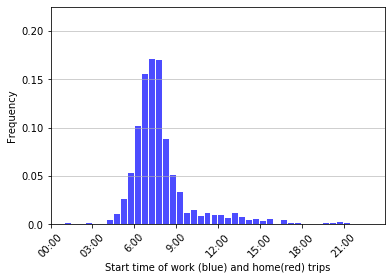

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=upsampled_wl['work_journey_start_time'], bins=np.arange(1,24,.5), color='blue', alpha=0.7, rwidth=0.85, density=1)
#n, bins, patches = plt.hist(x=upsampled_wl['work_journey_start_time'], bins=np.arange(1,24,.5), color='grey',
                           # alpha=0.7, rwidth=0.85, density=1) #, stacked=True, density=True
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Start time of work (blue) and home(red) trips')
plt.ylabel('Frequency')
# plt.xlabel('Start time of work trip')
# plt.ylabel('Frequency')

# example data
#mu = 9  # mean of distribution
#sigma = 1  # standard deviation of distribution
# add a 'best fit' line
#y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
#plt.plot(bins, y, '--')
#tmp_wl = (work_length_distribution.total.values / work_length_distribution.total.values.max() / 2.7)-0.03
#plt.plot(np.arange(0,20,.5), tmp_wl[18:58], '--')
#plt.title('My Very Own Histogram')
#plt.text(23, 45, r'$\mu=15, b=3$')
#maxfreq = n.max()
# Set a clean upper y-axis limit.

names_y = ['0.0','0.05','0.10','0.15','0.20']
ax.set_yticklabels(names_y)

names_x = ['00:00','03:00','6:00','9:00','12:00','15:00','18:00','21:00']
ax.set_xticklabels(names_x,rotation=45)

plt.yticks(np.arange(0, 0.45, 0.1))
plt.ylim(ymax=0.45, ymin=0)
plt.xticks(np.arange(0, 24, 3))
plt.xlim(xmax=24, xmin=0)

#work_length_distribution = get_time_distr(upsampled_wl)
#work_length_distribution

print(upsampled_wl['work_journey_start_time'].mean())

In [51]:
ax.hist(x=upsampled_wl['home_journey_start_time'], bins=np.arange(1,24,.5), color='red',
                            alpha=0.7, rwidth=0.85, density=1) #, stacked=True, density=True

(array([0.00445583, 0.        , 0.00257067, 0.        , 0.00264684,
        0.        , 0.0074835 , 0.        , 0.0034466 , 0.00064743,
        0.00198037, 0.00123773, 0.00803572, 0.00158049, 0.0016757 ,
        0.        , 0.00209462, 0.00346564, 0.00224696, 0.00268492,
        0.00198037, 0.00483667, 0.02071769, 0.01091106, 0.01980368,
        0.01669983, 0.05297484, 0.05697366, 0.11800326, 0.14441451,
        0.41507745, 0.33513915, 0.27810837, 0.10189373, 0.10876789,
        0.03412326, 0.05192753, 0.01742343, 0.0468814 , 0.01871828,
        0.03235235, 0.0155954 , 0.02056536, 0.01451   , 0.01534785]),
 array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
         6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5,
        12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. ,
        17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5,
        23. , 23.5]),
 <a list of 45 Patch objects>)

In [52]:
fig.savefig('data/time.svg')

16.4844316974116


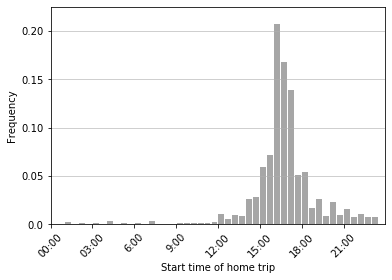

In [13]:
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(111)

ax.hist(x=upsampled_wl['home_journey_start_time'], bins=np.arange(1,24,.5), color='grey',
                            alpha=0.7, rwidth=0.85, density=1) #, stacked=True, density=True
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Start time of home trip')
plt.ylabel('Frequency')

# example data
#mu = 9  # mean of distribution
#sigma = 1  # standard deviation of distribution
# add a 'best fit' line
#y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
#plt.plot(bins, y, '--')
#tmp_wl = (work_length_distribution.total.values / work_length_distribution.total.values.max() / 2.7)-0.03
#plt.plot(np.arange(0,20,.5), tmp_wl[18:58], '--')
#plt.title('My Very Own Histogram')
#plt.text(23, 45, r'$\mu=15, b=3$')
#maxfreq = n.max()
# Set a clean upper y-axis limit.


names_y = ['0.0','0.05','0.10','0.15','0.20']
ax.set_yticklabels(names_y)

names_x = ['00:00','03:00','6:00','9:00','12:00','15:00','18:00','21:00']
ax.set_xticklabels(names_x,rotation=45)

plt.yticks(np.arange(0, 0.45, 0.1))
plt.ylim(ymax=0.45, ymin=0)
plt.xticks(np.arange(0, 24, 3))
plt.xlim(xmax=24, xmin=0)

plt.ylim(ymax=0.45, ymin=0)
plt.xlim(xmax=24, xmin=0)

#work_length_distribution = get_time_distr(upsampled_wl)
#work_length_distribution

print(upsampled_wl['home_journey_start_time'].mean())

NameError: name 'merged' is not defined

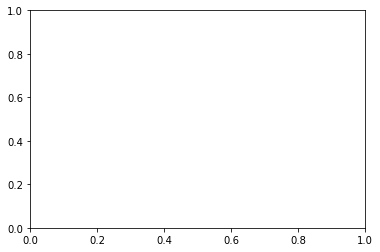

In [14]:
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(111)

ax.hist(x=merged, bins=np.arange(1,24,.5), color='grey',
                            alpha=0.7, rwidth=0.85, density=1) #, stacked=True, density=True
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Start time of commuting trips')
plt.ylabel('Frequency')

# example data
#mu = 9  # mean of distribution
#sigma = 1  # standard deviation of distribution
# add a 'best fit' line
#y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
#plt.plot(bins, y, '--')
#tmp_wl = (work_length_distribution.total.values / work_length_distribution.total.values.max() / 2.7)-0.03
#plt.plot(np.arange(0,20,.5), tmp_wl[18:58], '--')
#plt.title('My Very Own Histogram')
#plt.text(23, 45, r'$\mu=15, b=3$')
#maxfreq = n.max()
# Set a clean upper y-axis limit.


names_y = ['0.0','0.05','0.10','0.15','0.20']
ax.set_yticklabels(names_y)

names_x = ['00:00','03:00','6:00','9:00','12:00','15:00','18:00','21:00']
ax.set_xticklabels(names_x,rotation=45)

plt.yticks(np.arange(0, 0.45, 0.1))
plt.ylim(ymax=0.45, ymin=0)
plt.xticks(np.arange(0, 24, 3))
plt.xlim(xmax=24, xmin=0)

plt.ylim(ymax=0.25, ymin=0)
plt.xlim(xmax=24, xmin=0)


#work_length_distribution = get_time_distr(upsampled_wl)
#work_length_distribution

print(merged.mean())

8.576215870846935
1.931931497878427


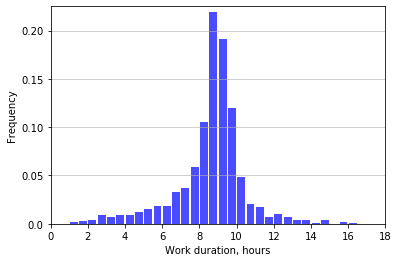

In [32]:
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(111)

ax.hist(x=upsampled_wl['time_int'], bins=np.arange(1,18,.5), color='blue',
                            alpha=0.7, rwidth=0.85, density=1) #, stacked=True, density=True
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Work duration, hours')
plt.ylabel('Frequency')

# example data
#mu = 9  # mean of distribution
#sigma = 1  # standard deviation of distribution
# add a 'best fit' line
#y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
#plt.plot(bins, y, '--')
#tmp_wl = (work_length_distribution.total.values / work_length_distribution.total.values.max() / 2.5)-0.018
#plt.plot(np.arange(0,20,.5), tmp_wl[18:58], '--')
#plt.title('My Very Own Histogram')
#plt.text(23, 45, r'$\mu=15, b=3$')
#maxfreq = n.max()
# Set a clean upper y-axis limit.


names_y = ['0.0','0.05','0.10','0.15','0.20']
ax.set_yticklabels(names_y)

#names_x = ['0','3','6','9','12','15','18:00','21:00']
#ax.set_xticklabels(names_x,rotation=45)

plt.yticks(np.arange(0, 0.45, 0.1))
plt.ylim(ymax=0.45, ymin=0)
#plt.xticks(np.arange(0, 24, 3))
#plt.xlim(xmax=24, xmin=0)

plt.ylim(ymax=0.45, ymin=0)
plt.xlim(xmax=18, xmin=0)


#work_length_distribution = get_time_distr(upsampled_wl)
#work_length_distribution

print(upsampled_wl['time_int'].mean())
print(upsampled_wl['time_int'].std())

In [33]:
fig.savefig('data/work_duration.svg')

In [ ]:
plot(work_length_distribution.total.values)


In [ ]:
work_length_distribution.idxmax()

## trip start distribution

In [244]:
upsampled_resfil.loc[:, 'rf2_starttid'] = upsampled_resfil.rf2_starttid.replace({'99': np.NaN,
                                                                          '18.45': '18:45',
                                                                          '1900-': '19:00',
                                                                          '1 9:4': '19:4'})
upsampled_resfil = upsampled_resfil.dropna()

In [119]:
upsampled_resfil['minute'] = np.NaN
upsampled_resfil['hour'] = np.NaN

In [120]:
upsampled_resfil['time'] = upsampled_resfil.rf2_starttid.astype(str).apply(lambda x: x.split(':')).values

In [121]:
upsampled_resfil.loc[:, ['hour']] = upsampled_resfil['time'].apply(lambda x: x[0])
upsampled_resfil.loc[:, ['hour']] = upsampled_resfil.hour.astype(int)
upsampled_resfil.loc[:, ['minute']] = upsampled_resfil['time'].apply(lambda x: x[1])
upsampled_resfil.loc[:, ['minute']] = upsampled_resfil.minute.astype(int)

In [122]:
upsampled_resfil['time_int'] = upsampled_resfil.hour + (upsampled_resfil.minute / 60.)

In [123]:
comm_time_distribution = get_time_distr(upsampled_resfil)

In [124]:
comm_time_distribution.head()

,total
"[0.0, 0.25)",655.00
"[0.25, 0.5)",862.25
"[0.5, 0.75)",961.50
"[0.75, 1.0)",951.00
"[1.0, 1.25)",880.00


In [125]:
work_time_distribution = get_time_distr(upsampled_resfil[upsampled_resfil['ärende_2'] == 1])
school_time_distribution = get_time_distr(upsampled_resfil[upsampled_resfil['ärende_2'] == 2])
home_time_distribution = get_time_distr(upsampled_resfil[upsampled_resfil['ärende_2'] == 10])

In [23]:
#plot(comm_time_distribution.total.values)
#plot(work_time_distribution.total.values)
#plot(school_time_distribution.total.values)
#plot(home_time_distribution.total.values)

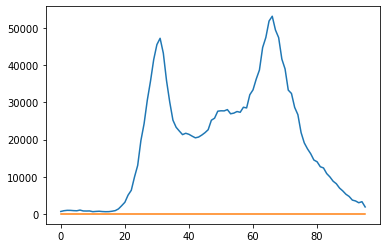

In [127]:
plot(comm_time_distribution.total.values)
for i in [range(1,11)]:
    distr = get_time_distr(upsampled_resfil[upsampled_resfil['ärende_2'] == i])
    plot(distr.values)

# Data preparation

In [25]:
buildings = pd.read_csv('data/GIS/buildings/buildings_zone_codes.csv', sep=';', index_col=0)

/home/ai6644/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
buildings.iloc[0:1]

,OBJEKT_ID,OBJEKT_VER,DETALJTYP,ADAT,INSAM_LAGE,XYFEL,NAMN1,NAMN2,NAMN3,HUVUDBYGGN,...,ANDAMAL_3,ANDAMAL_4,ANDAMAL_5,ANDAMAL_6,ANDAMAL_7,ANDAMAL_8,ANDAMAL_9,ANDAMAL_10,geometry,zone
0,edd3c338-6f5c-4ccc-a86f-7c9e952a9251,4,HUS,2015-02-26 11:53,3,80,NaN,NaN,NaN,J,...,0,0,0,0,0,0,0,0,POINT (13.32784938676369 55.43775595108503),1287


In [27]:
od_matrix = pd.read_csv('data/od_matrix.csv', sep=';', index_col=0)
od_matrix.iloc[0:1]

,1214,1230,1231,1233,1256,1257,1260,1261,1262,1263,...,12700011,12700012,12700013,12700014,12700015,12700016,12700017,12700018,12700019,12700020
1214,6138.29941,31.150788,71.925811,19.371292,2.376985,8.337177,685.316762,2645.21521,306.347163,12.306166,...,0.00441,0.004961,0.005549,0.001101,0.014959,0.012406,0.001678,0.000058,0.000041,0.000658


# Assigning building's position for persons

In [28]:
origin = od_matrix.index[0]
destination = int(od_matrix.loc[origin].sample(1, weights=od_matrix.loc[origin].values).index[0])
origin_buildings = buildings[buildings.zone == origin]
destionation_buildings = buildings[buildings.zone == destination]

In [29]:
class Population:
    def __init__(self):
        self.persons = []
    def to_JSON(self):
        return json.dumps(self, default=lambda o: _try(o), sort_keys=True, indent=4, separators=(',',':'))


class Person:
    def __init__(self):
        self.activities = []
        
#    def toJSON(self):
#        return json.dumps(self, default=lambda o: o.__dict__, 
#            sort_keys=True, indent=4)
        
    def to_JSON(self):
        return json.dumps(self, default=lambda o: _try(o), sort_keys=True, indent=4, separators=(',',':'))
        
def _try(o):
    try:
        if o.__class__ == ActivityType:
            raise Exception()
        return o.__dict__
    except:
        return str(o)

from enum import Enum
class ActivityType(Enum):
    HOME = 'HOME'
    WORK = 'WORK'

    def __str__(self):
        return self.name
    
class Activity(object):
    """Activity that is performed by a person.
    Person moves to a next activity after end_time is reached.

    Parameters
    ----------
    type_ : <ActivityType>
    coord : <Coord>
    start_time : <int> seconds from 00:00
    end_time : <int> seconds from 00:00
    """

    def __init__(self, type_, coord, start_time=None, end_time=None, zone=None):
        """docstring"""
        if start_time is None and end_time is None:
            raise Exception("Sanity check: both activity times are None")
        self.type = type_
        self.coord = coord
        self.start_time = start_time
        self.end_time = end_time
        self.zone = zone

    def __str__(self):
        return 'An ' + str(self.type) + ' at ' + str(self.coord)

In [30]:
def form_datetime(x):
    if type(x) == np.float64:
        m = (x - math.trunc(x)) * 60
        s = math.trunc((m - math.trunc(m)) * 60)
        m = math.trunc(m)
        h = math.trunc(x)
        return datetime(year = 1970, month = 1 ,day = 1, hour = h, minute=m, second = s)
    elif type(x) == time:
        return datetime(year = 1970, month = 1 ,day = 1, hour = x.hour, minute=x.minute, second = x.second)
    
def form_td(x):
    if type(x) == np.float64:
        m = (x - math.trunc(x)) * 60
        s = math.trunc((m - math.trunc(m)) * 60)
        m = math.trunc(m)
        h = math.trunc(x)
        return td(hours = h, minutes=m, seconds = s)
    elif type(x) == time:
        return td(hours = x.hour, minutes=x.minute, seconds = x.second)

In [31]:
datetime(year = 1970, month = 1 ,day = 1, hour = 23) + td(minutes=90)

datetime.datetime(1970, 1, 2, 0, 30)

In [32]:
a = datetime(year = 1970, month = 1 ,day = 1, hour = 23)
b = td(minutes=90)
(a + b).date()

datetime.date(1970, 1, 2)

In [33]:
datetime(year = 1970, month = 1 ,day = 1, hour = 1).time() < time(1,30)

True

# Main cycle

In [34]:
time_window = td(minutes = 90)
time_check = time(1, 30)

population = Population()

def sample_time(time_distr):
    time_bin = time_distr.sample(1, weights='total').index
    return form_datetime(random.uniform(time_bin.left, time_bin.right)[0]).time()

def form_activity(zone, act_type, coord=None, buildings=None, s_time=None, s_distr=None, e_time=None, e_distr=None, l_distr=None):
    """Combines an activity out of provided locations, type and times
    
    Parameters
    ----------
    coord, buildings: exact coordinate or pd.Dataframe of buildings
    s_time, s_distr: starting time or time distribution.
    e_time, e_distr: end time or distribution.
    l_distr: distribution of activity duration. Added to start time
    """
    if coord is not None:
        location = coord
    else:
        coord = shapely.wkt.loads(buildings.sample(1).geometry.values[0])
        location = Coord(lat=coord.y, lon=coord.x)
    
    if s_time is not None:
        start_time = s_time
    else:
        start_time = sample_time(s_distr)
        
    if e_time is not None:
        end_time = e_time
    elif l_distr is not None:
        end_time_tmp = form_datetime(start_time) + form_td(sample_time(l_distr))
        if end_time_tmp.date() != form_datetime(start_time).date():
            end_time = time(23,59,59)
        else:
            end_time = end_time_tmp.time()
    else:
        end_time = sample_time(e_distr)
        
    return Activity(act_type,
                   location,
                   start_time=start_time,
                   end_time=end_time,
                   zone=zone
                  )

for origin, destinations in od_matrix.iterrows():
    
    for destination, pop in destinations.iteritems():
        # only calculate persons that go to, from or within target zones         
        if int(origin) < 12650000 and int(destination) < 12650000:
            continue
        #destination = int(destinations.sample(1, weights=destinations.values).index[0])
        origin_buildings = buildings[buildings.zone == origin]
        destionation_buildings = buildings[buildings.zone == int(destination)]
        
        print(origin, destination, round(pop))
        for pers in range(round(pop)):
            new_pers = Person()
            
            # home activity
            act = form_activity(buildings = origin_buildings, 
                                zone =origin, 
                                act_type = ActivityType.HOME,
                                s_time = time(0),
                                e_distr = work_time_distribution)          
            new_pers.activities.append(act)
            
            # work activity            
            act = form_activity(buildings = destionation_buildings, 
                    zone = destination, 
                    act_type = ActivityType.WORK,
                    s_time = new_pers.activities[-1].end_time,
                    l_distr = work_length_distribution)
            # make sure work is not in the same place
            while act.coord == new_pers.activities[-1].coord:
                act = form_activity(buildings = destionation_buildings, 
                    zone = int(destination), 
                    act_type = ActivityType.WORK,
                    s_time = new_pers.activities[-1].end_time,
                    l_distr = work_length_distribution)
            new_pers.activities.append(act)
            
            # back home activity
            act = form_activity(coord = new_pers.activities[0].coord, 
                    zone = origin, 
                    act_type = ActivityType.HOME,
                    s_time = new_pers.activities[-1].end_time,
                    e_time = time(23,59,59))
            new_pers.activities.append(act)
            
            population.persons.append(new_pers)
            

#        print(origin, destination, round(pop))
            
#        break
#    break
    

1214 12650001 0
1214 12650002 0
1214 12650003 0
1214 12650004 0
1214 12650005 0
1214 12650006 0
1214 12650007 0
1214 12650008 0
1214 12650009 0
1214 12650010 0
1214 12650011 0
1214 12650012 0
1214 12650013 0
1214 12650014 0
1214 12650015 0
1214 12650016 0
1214 12650017 0
1214 12700001 0
1214 12700002 0
1214 12700003 0
1214 12700004 0
1214 12700005 0
1214 12700006 0
1214 12700007 0
1214 12700008 0
1214 12700009 0
1214 12700010 0
1214 12700011 0
1214 12700012 0
1214 12700013 0
1214 12700014 0
1214 12700015 0
1214 12700016 0
1214 12700017 0
1214 12700018 0
1214 12700019 0
1214 12700020 0
1230 12650001 1
1230 12650002 0
1230 12650003 4
1230 12650004 5
1230 12650005 5
1230 12650006 1
1230 12650007 7
1230 12650008 4
1230 12650009 0
1230 12650010 0
1230 12650011 0
1230 12650012 0
1230 12650013 0
1230 12650014 1
1230 12650015 1
1230 12650016 0
1230 12650017 1
1230 12700001 0
1230 12700002 0
1230 12700003 0
1230 12700004 0
1230 12700005 1
1230 12700006 0
1230 12700007 0
1230 12700008 0
1230 127

1273 12650015 0
1273 12650016 0
1273 12650017 0
1273 12700001 0
1273 12700002 0
1273 12700003 0
1273 12700004 0
1273 12700005 0
1273 12700006 0
1273 12700007 0
1273 12700008 0
1273 12700009 0
1273 12700010 0
1273 12700011 0
1273 12700012 0
1273 12700013 0
1273 12700014 0
1273 12700015 0
1273 12700016 0
1273 12700017 0
1273 12700018 0
1273 12700019 0
1273 12700020 0
1275 12650001 0
1275 12650002 0
1275 12650003 0
1275 12650004 0
1275 12650005 0
1275 12650006 0
1275 12650007 0
1275 12650008 0
1275 12650009 0
1275 12650010 0
1275 12650011 0
1275 12650012 0
1275 12650013 0
1275 12650014 0
1275 12650015 0
1275 12650016 0
1275 12650017 0
1275 12700001 0
1275 12700002 0
1275 12700003 0
1275 12700004 0
1275 12700005 0
1275 12700006 0
1275 12700007 0
1275 12700008 0
1275 12700009 0
1275 12700010 0
1275 12700011 0
1275 12700012 0
1275 12700013 0
1275 12700014 0
1275 12700015 0
1275 12700016 0
1275 12700017 0
1275 12700018 0
1275 12700019 0
1275 12700020 0
1276 12650001 0
1276 12650002 0
1276 126

1291 12650012 33
1291 12650013 6
1291 12650014 5
1291 12650015 2
1291 12650016 1
1291 12650017 1
1291 12700001 64
1291 12700002 5
1291 12700003 13
1291 12700004 29
1291 12700005 156


KeyboardInterrupt: 

In [ ]:
j = json.loads(population.to_JSON())

In [ ]:
j

In [42]:
with open('/data/population2.json', 'w') as outfile:
    json.dump(j, outfile)